In [2]:
import pandas as pd
import numpy as np
from numpy import dot
from numpy.linalg import norm
import json

import gzip
import math
from math import log
import scipy.optimize
import random
import string
import os
import pickle
import itertools
import re
from tqdm import tqdm
import scipy.sparse as sparse
import pyrsm as rsm
import statsmodels.formula.api as smf
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from collections import defaultdict

import gensim.models
import gensim.downloader as api
from gensim.test.utils import common_texts
from gensim.models import word2vec
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit

import en_core_web_sm
nlp_processor = en_core_web_sm.load()
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.porter import *

import sklearn
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

from wordcloud import WordCloud
from statsmodels.stats.outliers_influence import variance_inflation_factor

/usr/local/lib/python3.8/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
path = "renttherunway_final_data.json"

dataset = []
for line in open(path, 'r'):
    dataset.append(json.loads(line))
    
dataset[0]

{'fit': 'fit',
 'user_id': '420272',
 'bust size': '34d',
 'item_id': '2260466',
 'weight': '137lbs',
 'rating': '10',
 'rented for': 'vacation',
 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
 'body type': 'hourglass',
 'review_summary': 'So many compliments!',
 'category': 'romper',
 'height': '5\' 8"',
 'size': 14,
 'age': '28',
 'review_date': 'April 20, 2016'}

# Data Pre-process and Explore Data Analysis

In [4]:
df_raw = pd.DataFrame(dataset)

In [5]:
# display first 5 rows
df_raw.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27,"September 26, 2016"


In [6]:
# check columns types
df_raw.dtypes

fit               object
user_id           object
bust size         object
item_id           object
weight            object
rating            object
rented for        object
review_text       object
body type         object
review_summary    object
category          object
height            object
size               int64
age               object
review_date       object
dtype: object

In [7]:
# check the proportion of null values
df_raw.isnull().sum()/df_raw.shape[0]

fit               0.000000
user_id           0.000000
bust size         0.095620
item_id           0.000000
weight            0.155715
rating            0.000426
rented for        0.000052
review_text       0.000000
body type         0.076019
review_summary    0.000000
category          0.000000
height            0.003516
size              0.000000
age               0.004986
review_date       0.000000
dtype: float64

In [8]:
# get modes of columns to fill in missing values
col_feature = ["bust size","weight","body type","height","size","age"]

In [9]:
df_raw.loc[:,col_feature].mode()

,bust size,weight,body type,height,size,age
0,34b,130lbs,hourglass,"5' 4""",8,31


In [10]:
# data pre-processing
for i in dataset:
    if 'rented for' not in i.keys():
        dataset.remove(i)
    elif (i['rating'] == None) or (len(i['review_text']) == 0) or (len(i['fit']) == 0) or (len(i['category']) == 0) or (len(i['rented for']) == 0): 
        dataset.remove(i)
len(dataset)

192452

In [11]:
bust_size =  []
for d in dataset:
    if 'bust size' in d.keys():
        bust_size.append(d['bust size'])
    else:
        bust_size.append(0)
bust_number = []
cup = []
for b in bust_size:
    if b != 0 :
        bust_number.append(int(b[0:2]))
        cup.append(b[2:])
    else:
        bust_number.append(34)
        cup.append('b')
body_type =  []
for d in dataset:
    if 'body type' in d.keys():
        body_type.append(d['body type'])
    else:
        body_type.append('hourglass')
weight =  []
for d in dataset:
    if 'weight' in d.keys():
        weight.append(int(d['weight'].split('l',1)[0]))
    else:
        weight.append(130)
height =  []
for d in dataset:
    if 'height' in d.keys():
        height.append(12*int(d['height'].split("\' ")[0])+int(d['height'].split("\' ")[1].split('"')[0]))
    else:
        height.append(64)
size =  []
for d in dataset:
    if 'size' in d.keys():
        size.append(d['size'])
    else:
        size.append(8)
age =  []
for d in dataset:
    if 'age' in d.keys():
        age.append(int(d['age']))
    else:
        age.append(31)
fit = [d['fit'] for d in dataset]
rate = [(d['rating']) for d in dataset]
category = [d['category'] for d in dataset]
rent =  []
for d in dataset:
    if 'rented for' in d.keys():
        rent.append(d['rented for'])
    else:
        rent.append('Unknown')
reviews = [d['review_text'] for d in dataset]

In [12]:
df_clean = pd.DataFrame({'fit': fit, 'rating': rate, 'category': category, 'rent_for': rent, 
                  'bust_number': bust_number, 'cup': cup, 'body_type': body_type, 'weight' : weight, 'height': height, 
                  'size': size, 'age': age, 'review_text': reviews})

In [13]:
df_clean.head()

,fit,rating,category,rent_for,bust_number,cup,body_type,weight,height,size,age,review_text
0,fit,10,romper,vacation,34,d,hourglass,137,68,14,28,An adorable romper! Belt and zipper were a lit...
1,fit,10,gown,other,34,b,straight & narrow,132,66,12,36,I rented this dress for a photo shoot. The the...
2,fit,10,sheath,party,34,b,hourglass,130,64,4,116,This hugged in all the right places! It was a ...
3,fit,8,dress,formal affair,34,c,pear,135,65,8,34,I rented this for my company's black tie award...
4,fit,10,gown,wedding,34,b,athletic,145,69,12,27,I have always been petite in my upper body and...


In [14]:
# Plotting barplots for response variables
# increase plot resolution
mpl.rcParams["figure.dpi"] = 80

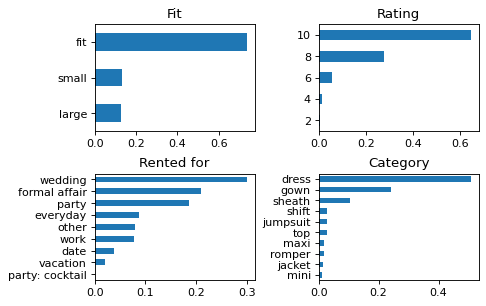

In [15]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

df_clean.fit.value_counts(normalize=True,ascending=True).plot(kind='barh',ax=ax1)
df_clean.rating.value_counts(normalize=True,ascending=True).plot(kind='barh',ax=ax2)
df_clean.rent_for.value_counts(normalize=True,ascending=True).plot(kind='barh',ax=ax3)
category_sort = df_clean.category.value_counts().reset_index().sort_values(by=['category'],ascending=False)
category_top10 = list(category_sort['index'][:10])
df_clean[df_clean.category.isin(category_top10)].category.value_counts(normalize=True,ascending=True).plot(kind='barh',ax=ax4)
#fig.suptitle('Proportion of Variables',y=1.0)
ax1.set_title('Fit')
ax2.set_title('Rating')
ax3.set_title('Rented for')
ax4.set_title('Category')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

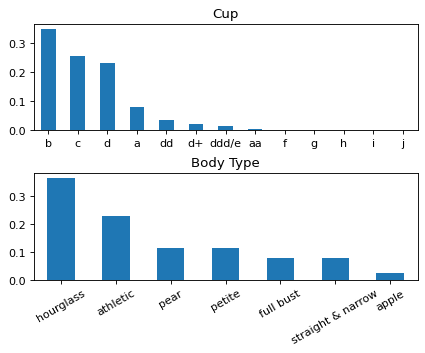

In [15]:
fig, (ax1, ax2) = plt.subplots(2)
df_clean.cup.value_counts(normalize=True,ascending=False).plot(kind='bar',ax=ax1, rot=0)
df_clean.body_type.value_counts(normalize=True,ascending=False).plot(kind='bar',ax=ax2, rot=30)
#fig.suptitle('Proportion of Categorical Features',y=1.0)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
ax1.set_title('Cup')
ax2.set_title('Body Type')
plt.show()

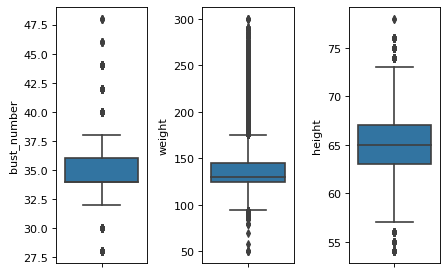

In [16]:
#mpl.rcParams["figure.dpi"] = 80
fig, axes = plt.subplots(1,3)
sns.boxplot(y=df_clean.bust_number,ax=axes[0])
sns.boxplot(y=df_clean.weight,ax=axes[1])
sns.boxplot(y=df_clean.height,ax=axes[2])
#fig.suptitle('Boxplot of Features',y=1.0)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.6, 
                    hspace=0.4)
plt.show()

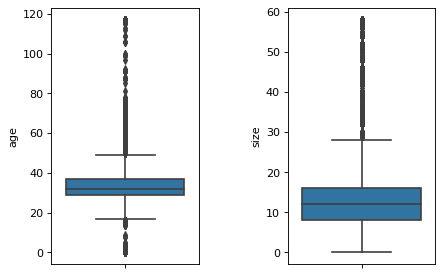

In [17]:
#mpl.rcParams["figure.dpi"] = 80
fig, axes = plt.subplots(1,2)
sns.boxplot(y=df_clean["age"],ax=axes[0])
sns.boxplot(y=df_clean["size"],ax=axes[1])
#fig.suptitle('Boxplot of Features',y=1.0)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.6, 
                    hspace=0.4)
plt.show()

#### Since there are unreasonable value in age, we decided to change those <15 and >70 to mode(31)

In [18]:
df_clean.loc[(df_clean['age'] > 70) | (df_clean['age'] < 15), 'age'] = 31

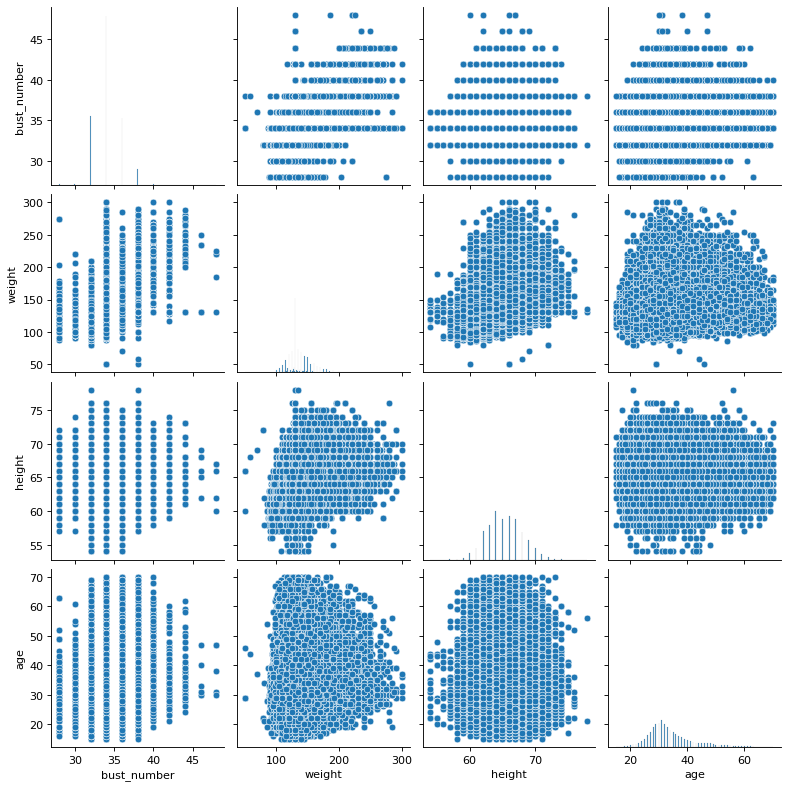

In [19]:
mpl.rcParams["figure.dpi"] = 80
sns.pairplot(data = df_clean, vars=["bust_number","weight","height","age"])
plt.show()

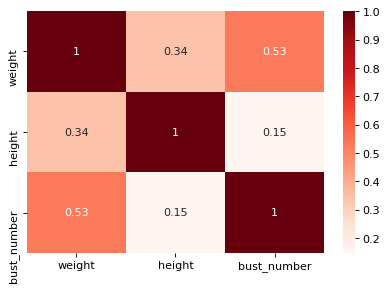

In [20]:
#mpl.rcParams["figure.dpi"] = 150
# Creating a matrix using age, salry, balance as rows and columns
df_clean[['weight','height','bust_number']].corr()

#plot the correlation matrix of salary, balance and age in data dataframe.
sns.heatmap(df_clean[['weight','height','bust_number']].corr(), annot=True, cmap = 'Reds')
plt.show()

In [21]:
# Output wordcloud
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
stemmer = PorterStemmer()
stopWords = stopwords.words('english')

In [22]:
review_summary = []
for d in dataset:
    r = ''.join([c for c in d['review_summary'].lower()])
    for w in r.split():
        #w = stemmer.stem(w)
        if (w not in punctuation) and (w not in stopWords):
            review_summary.append(w)

In [23]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))

ps = PorterStemmer() 

# return a list of tokens
def pre_processing_by_nltk(doc, stemming = True, need_sent = False):
    # step 1: get sentences
    sentences = sent_tokenize(doc)
    # step 2: get tokens
    tokens = []
    for sent in sentences:
        words = word_tokenize(sent)
        # step 3: stemming
        if stemming:
            words = [ps.stem(word) for word in words]
        if need_sent:
            tokens.append(words)
        else:
            tokens += words
    # remove stop words and punctuations in reutrns
    return [w.lower() for w in tokens if w.lower() not in stop if w.isalnum()]

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


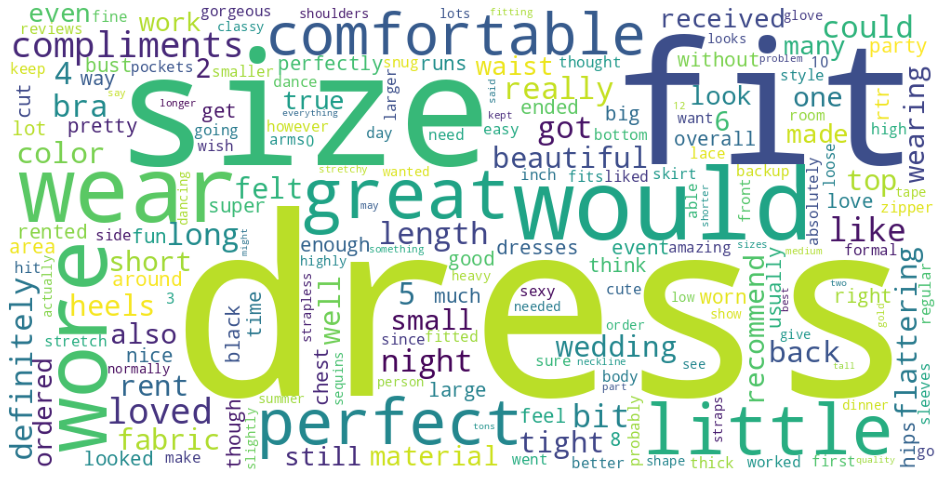

In [24]:
review_text = np.array(df_clean["review_text"].agg(pre_processing_by_nltk, stemming = False, need_sent = False))
review_text = review_text.reshape(-1).tolist()
review_text_lst = [i for lst in review_text for i in lst]
reviewtext_dict=Counter(review_text_lst)
reviewtext_wordcloud = WordCloud(width = 1000, height = 500, background_color='white').generate_from_frequencies(reviewtext_dict)

plt.figure(figsize=(15,8))
plt.imshow(reviewtext_wordcloud)
plt.axis("off")
plt.show()

# Use 50K data choose model

In [16]:
df_clean.shape

(192452, 12)

In [17]:
dataset_50k = df_clean.sample(frac=1,random_state=42).reset_index(drop=True)[:50000]
dataset_50k.shape

(50000, 12)

# Baseline (without review_text)

In [27]:
dataset_50k.head()

,fit,rating,category,rent_for,bust_number,cup,body_type,weight,height,size,age,review_text
0,large,10,maxi,party,34,b,pear,140,64,8,36,I straddle the 4/6 sizes and this fit me perfe...
1,fit,10,gown,formal affair,32,d,hourglass,130,63,8,31,I didn't want to send it back! The 4 fit perf...
2,fit,10,sheath,formal affair,32,d,athletic,142,68,12,30,"Fit great, if you are between sizes order up, ..."
3,fit,10,dress,wedding,38,c,apple,175,67,20,31,I went out on a limb with this dress - all the...
4,fit,8,midi,wedding,36,ddd/e,full bust,170,69,24,31,"It is low, although you're covered you can see..."


In [18]:
df = pd.get_dummies(dataset_50k, columns = ['cup','body_type'])

In [19]:
X = df[['bust_number', 'weight',
       'height', 'size', 'age', 'cup_a', 'cup_aa', 'cup_b',
       'cup_c', 'cup_d', 'cup_d+', 'cup_dd', 'cup_ddd/e', 'cup_f', 'cup_g',
       'cup_h', 'cup_i', 'cup_j', 'body_type_apple', 'body_type_athletic',
       'body_type_full bust', 'body_type_hourglass', 'body_type_pear',
       'body_type_petite', 'body_type_straight & narrow']]
X_fit_train, X_fit_test, y_fit_train, y_fit_test = train_test_split(X, df.loc[:,'fit'], random_state=42, test_size=0.2, shuffle=True)
X_rate_train, X_rate_test, y_rate_train, y_rate_test = train_test_split(X,df.loc[:,'rating'], random_state=42, test_size=0.2, shuffle=True)

In [21]:
# Test for multicollinearity
X['intercept'] =1
vif = variance_inflation_factor(X.values, 1)
vif

<ipython-input-21-c2510b5486bd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] =1


2.2781909944415895

In [29]:
def eval(model, x, true):
    auroc = roc_auc_score(true, model.predict_proba(x), multi_class = 'ovr')
    f1_mac = f1_score(true, model.predict(x), average='macro')
    f1_mic = f1_score(true, model.predict(x), average='micro')
    accuracy = accuracy_score(true, model.predict(x))
    print("auroc_rate: ", auroc)
    print("f1_mac_rate: ", f1_mac)
    print("f1_mic_rate: ", f1_mic)
    print("accuracy_rate: ", accuracy)
    
    return(auroc, f1_mac, f1_mic, accuracy)

In [31]:
X_fit_train_sparse = sparse.csr_matrix(X_fit_train)
X_rate_train_sparse = sparse.csr_matrix(X_rate_train)

In [32]:
clf_fit_base = LogisticRegression(max_iter=100000000,C=1).fit(X_fit_train, y_fit_train)
auroc_fit_base, f1_mac_fit_base, f1_mic_fit_base, accuracy_fit_base = eval(clf_fit_base, sparse.csr_matrix(X_fit_test), y_fit_test)

auroc_rate:  0.5866287174095914
f1_mac_rate:  0.28463118112481195
f1_mic_rate:  0.7338999999999999
accuracy_rate:  0.7339


In [33]:
clf_rate_base = LogisticRegression(max_iter=100000000,C=1).fit(X_rate_train, y_rate_train)
auroc_rate_base, f1_mac_rate_base, f1_mic_rate_base, accuracy_rate_base = eval(clf_rate_base,sparse.csr_matrix( X_rate_test), y_rate_test)

auroc_rate:  0.5455740291115136
f1_mac_rate:  0.15766387980128438
f1_mic_rate:  0.6506
accuracy_rate:  0.6506


# Add Text

## TFIDF

In [34]:
# Text Pre-Processing
stop_words = set(stopwords.words('english'))
newStopWords = ['actually', 'also', 'although',
    'always', 'became', 'become', 'could','do', 'does', 'either', 'else','hence','how', 'may', 'to', 'on'
    'maybe','me','might','mine','must','my','of','oh','ok','whereas','wherever',
    'whenever','whether','whoever','whose','why','will','within','with','without','yet','your', 'would', 'all']
stop_words.update(newStopWords)

# print(stop) must be lowercase an √ ； AN X
ps = PorterStemmer() 

# return a list of tokens
def pre_processing_by_nltk(doc, stemming = True, need_sent = False):
    # step 1: get sentences
    sentences = sent_tokenize(doc)
    # step 2: get tokens
    tokens = []
    for sent in sentences:
        words = word_tokenize(sent)
        # step 3: stemming
        if stemming:
            words = [ps.stem(word) for word in words]
        if need_sent:
            tokens.append(words)
        else:
            tokens += words
    return [w.lower() for w in tokens if w.lower() not in stop_words]

# Create vocab
DF = defaultdict(float)
for doc in tqdm(df.review_text):
    tokens = pre_processing_by_nltk(doc)
    for token in set(tokens):
        DF[token] += 1
        
IDF, vocab = dict(), dict()
for token in DF:
    if DF[token] < 15:
        # words (freq < 10) becomes an unk
        pass
    else:
        vocab[token] = len(vocab)
        IDF[token] = log(1 + len(df.review_text) / DF[token])

IDF['<UNK>'] = 1
vocab['<UNK>'] = len(vocab)

len(vocab)

100%|██████████| 50000/50000 [01:26<00:00, 579.70it/s]


2951

In [35]:
def tfidf_feature_extractor(doc, vocab, IDF):
    tokens = pre_processing_by_nltk(doc)
    for i, token in enumerate(tokens):
        if token not in vocab:
            tokens[i] = '<UNK>'
    TF = defaultdict(int)
    for token in tokens:
        TF[token] += 1
    x = [0] * len(vocab)
    for token in set(tokens):
        tfidf = log(TF[token] + 1) * IDF[token]
        token_id = vocab[token]
#         print(token, TF[token], IDF[token])
        x[token_id] = tfidf # this will be a dense matrix
    return x

In [36]:
X_review_tfidf = []
for doc in tqdm(df.review_text):
    X_review_tfidf.append(tfidf_feature_extractor(doc, vocab, IDF))
X_review = pd.DataFrame(np.array(X_review_tfidf))

100%|██████████| 50000/50000 [01:33<00:00, 532.47it/s]


In [37]:
X_add_idf = pd.concat([X,X_review],axis=1)

In [38]:
X_fit_train, X_fit_test, y_fit_train, y_fit_test = train_test_split(X_add_idf, df.loc[:,'fit'], random_state=42, test_size=0.2, shuffle=True)
X_rate_train, X_rate_test, y_rate_train, y_rate_test = train_test_split(X_add_idf,df.loc[:,'rating'], random_state=42, test_size=0.2, shuffle=True)
X_fit_train_sparse = sparse.csr_matrix(X_fit_train)
X_rate_train_sparse = sparse.csr_matrix(X_rate_train)

In [39]:
clf_fit_idf = LogisticRegression(max_iter=100000000,C=1).fit(X_fit_train_sparse, y_fit_train)
auroc_fit_idf, f1_mac_fit_idf, f1_mic_fit_idf, accuracy_fit_idf = eval(clf_fit_idf, sparse.csr_matrix(X_fit_test), y_fit_test)

auroc_rate:  0.790526609454432
f1_mac_rate:  0.6030773228208012
f1_mic_rate:  0.7731
accuracy_rate:  0.7731


In [40]:
clf_rate_idf = LogisticRegression(max_iter=100000000,C=1).fit(X_rate_train_sparse, y_rate_train)
auroc_rate_idf, f1_mac_rate_idf, f1_mic_rate_idf, accuracy_rate_idf = eval(clf_rate_idf, sparse.csr_matrix(X_rate_test), y_rate_test)

auroc_rate:  0.7883374631115887
f1_mac_rate:  0.34772206797681615
f1_mic_rate:  0.6721
accuracy_rate:  0.6721


## Word2Vec

In [41]:
def build_vocab(sentences):
    # Build vocabulary
    word_counts = Counter(itertools.chain(*sentences))
    # Mapping from index to word
    vocabulary_inv = [x[0] for x in word_counts.most_common()]
    # Mapping from word to index
    vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}
    return word_counts, vocabulary, vocabulary_inv

def get_embeddings(inp_data, vocabulary_inv, size_features=100,
                   mode='skipgram',
                   min_word_count=2,
                   context=5):
    model_name = "embedding"
    model_name = os.path.join(model_name)
    num_workers = 15  # Number of threads to run in parallel
    downsampling = 1e-3  # Downsample setting for frequent words
    print('Training Word2Vec model...')
    # use inp_data and vocabulary_inv to reconstruct sentences
    sentences = [[vocabulary_inv[w] for w in s] for s in inp_data]
    if mode == 'skipgram':
        sg = 1
        print('Model: skip-gram')
    elif mode == 'cbow':
        sg = 0
        print('Model: CBOW')
    embedding_model = word2vec.Word2Vec(sentences, workers=num_workers,
                                        sg=sg,
                                        vector_size=size_features,
                                        min_count=min_word_count,
                                        window=context,
                                        sample=downsampling)
    print("Saving Word2Vec model {}".format(model_name))
    embedding_weights = np.zeros((len(vocabulary_inv), size_features))
    for i in range(len(vocabulary_inv)):
        word = vocabulary_inv[i]
        if word in embedding_model.wv:
            embedding_weights[i] = embedding_model.wv[word]
        else:
            embedding_weights[i] = np.random.uniform(-0.25, 0.25,
                                                     embedding_model.vector_size)
    return embedding_weights

def preprocess_df(df):
    # get English stopwords
    stop_words = set(stopwords.words('english'))
    stop_words.add('would')
    # prepare translation table to translate punctuation to space
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    preprocessed_sentences = []
    for i, row in df.iterrows():
        sent = row["review_text"]
        sent_nopuncts = sent.translate(translator)
        words_list = sent_nopuncts.strip().split()
        filtered_words = [word for word in words_list if word not in stop_words and len(word) != 1] # also skip space from above translation
        preprocessed_sentences.append(" ".join(filtered_words))
    df["review_text"] = preprocessed_sentences
    return df

In [43]:
train = df[:len(df)//10*8]
test = df[len(df)//10*8:]

train_feature = X[:len(X)//10*8]
test_feature = X[len(X)//10*8:]

train = preprocess_df(train)
test = preprocess_df(test)

<ipython-input-41-424ecf821ad2>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["review_text"] = preprocessed_sentences


In [44]:
# tokenization 
tagged_data = [word_tokenize(_d) for i, _d in enumerate(train["review_text"])]
# build vocabulary from tokenized data
word_counts, vocabulary, vocabulary_inv = build_vocab(tagged_data)
# use the above mapping to create input data
inp_data = [[vocabulary[word] for word in text] for text in tagged_data]
# get embedding vector
embedding_weights = get_embeddings(inp_data, vocabulary_inv)

tagged_train_data = [word_tokenize(_d) for i, _d in enumerate(train["review_text"])]
tagged_test_data = [word_tokenize(_d) for i, _d in enumerate(test["review_text"])]

Training Word2Vec model...
Model: skip-gram
Saving Word2Vec model embedding


In [45]:
train_vec = []
for doc in tagged_train_data:
    vec = 0
    for w in doc:
        vec += embedding_weights[vocabulary[w]]
    if len(doc) != 0:
        vec = vec / len(doc)
    else: vec = [0] * 100
    train_vec.append(vec)

test_vec = []
for doc in tagged_test_data:
    vec = 0
    length = 0
    for w in doc:
        try:
            vec += embedding_weights[vocabulary[w]]
            length += 1
        except:
            continue
    if length != 0: 
        vec = vec / length
    else: vec = [0] * 100
    test_vec.append(vec)

In [46]:
train_vec_features = [np.append(i, j) for (i,j) in zip(train_vec, np.array(train_feature))]
test_vec_features = [np.append(i, j) for (i,j) in zip(test_vec, np.array(test_feature))]

train_just_features = [i for i in np.array(train_feature)]
test_just_features = [i for i in np.array(test_feature)]

In [47]:
model_fit_SG = LogisticRegression(C = 1, random_state=42, max_iter = 100000000).fit(train_vec_features, train['fit'])
auroc_fit_SG, f1_mac_fit_SG, f1_mic_fit_SG, accuracy_fit_SG  = eval(model_fit_SG, test_vec_features, test['fit'])

auroc_rate:  0.7852504496310196
f1_mac_rate:  0.48416385275120405
f1_mic_rate:  0.7669
accuracy_rate:  0.7669


In [48]:
model_rating_SG = LogisticRegression(C = 1, random_state=42, max_iter = 100000000).fit(train_vec_features, train['rating'])
auroc_rate_SG, f1_mac_rate_SG, f1_mic_rate_SG, accuracy_rate_SG = eval(model_rating_SG, test_vec_features, test['rating'])

auroc_rate:  0.8226084393207364
f1_mac_rate:  0.26879388027214113
f1_mic_rate:  0.6763
accuracy_rate:  0.6763


## CBOW

In [144]:
# get embedding vector
embedding_weights = get_embeddings(inp_data, vocabulary_inv, mode='cbow' )

tagged_train_data = [word_tokenize(_d) for i, _d in enumerate(train["review_text"])]
tagged_test_data = [word_tokenize(_d) for i, _d in enumerate(test["review_text"])]

Training Word2Vec model...
Model: CBOW
Saving Word2Vec model embedding


In [145]:
train_vec = []
for doc in tagged_train_data:
    vec = 0
    for w in doc:
        vec += embedding_weights[vocabulary[w]]
    if len(doc) != 0:
        vec = vec / len(doc)
    else: vec = [0] * 100
    train_vec.append(vec)

test_vec = []
for doc in tagged_test_data:
    vec = 0
    length = 0
    for w in doc:
        try:
            vec += embedding_weights[vocabulary[w]]
            length += 1
        except:
            continue
    if length != 0: 
        vec = vec / length
    else: vec = [0] * 100
    test_vec.append(vec)

In [146]:
train_vec_features = [np.append(i, j) for (i,j) in zip(train_vec, np.array(train_feature))]
test_vec_features = [np.append(i, j) for (i,j) in zip(test_vec, np.array(test_feature))]

In [147]:
model_fit_cbow = LogisticRegression(C = 1, random_state=42, max_iter = 100000000).fit(train_vec_features, train['fit'])
auroc_fit_cbow, f1_mac_fit_cbow, f1_mic_fit_cbow, accuracy_fit_cbow  = eval(model_fit_cbow, test_vec_features, test['fit'])

auroc_rate:  0.7948469125828606
f1_mac_rate:  0.508236085791458
f1_mic_rate:  0.7708
accuracy_rate:  0.7708


In [148]:
model_rating_cbow = LogisticRegression(C = 1, random_state=42, max_iter = 100000000).fit(train_vec_features, train['rating'])
auroc_rate_cbow, f1_mac_rate_cbow, f1_mic_rate_cbow, accuracy_rate_cbow = eval(model_rating_cbow, test_vec_features, test['rating'])

auroc_rate:  0.810268130641866
f1_mac_rate:  0.25538126948925366
f1_mic_rate:  0.6646
accuracy_rate:  0.6646


## Glove

In [97]:
tagged_train_data_list = []
for i in tagged_train_data:
    tagged_train_data_list.append(' '.join(i))
    
tagged_test_data_list = []
for i in tagged_test_data:
    tagged_test_data_list.append(' '.join(i))
glove_df_train = pd.DataFrame(tagged_train_data_list).rename(columns={0:'text'})
glove_df_test = pd.DataFrame(tagged_test_data_list).rename(columns={0:'text'})

In [59]:
glove_model = {}
with open ('glove.6B.100d.txt') as f:
    for line in f:
        line_split = line.split()
        word = line_split[0]
        embedding = np.array(line_split[1:], dtype=np.float64)  
        glove_model[word] = embedding

In [98]:
glove_model_new = {}
for k, v in glove_model.items():
    if v.size ==100:
        glove_model_new[k] = v

In [99]:
def cos_sim(a, b):
    return dot(a, b)/(norm(a)*norm(b))

def GloVe(doc, wv):
    vecs = []
    for token in doc.split():
        try:
            vecs.append(wv[token])
        except KeyError:
            vecs.append(np.array([0]*100))
    return np.mean(vecs, axis=0)

In [100]:
train_vec = []
for sent in glove_df_train.text:
    train_vec.append(GloVe(sent, glove_model_new))

test_vec = []
for sent in glove_df_test.text:
    test_vec.append(GloVe(sent, glove_model_new))

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [118]:
train_vec_features_df = pd.DataFrame(train_vec_features)
train_vec_features_df = pd.concat([train_vec_features_df, train[['fit', 'rating']]], axis=1)
test_vec_features_df = pd.DataFrame(test_vec_features)
test_vec_features_df = pd.concat([test_vec_features_df, test[['fit', 'rating']].reset_index()], axis=1)
train_vec_features_df = train_vec_features_df.dropna()
test_vec_features_df = test_vec_features_df.dropna()
test_vec_features_df = test_vec_features_df.drop(columns=['index'])

In [141]:
model_fit_Glove = LogisticRegression(C = 1, random_state=42, max_iter = 100000000).fit(train_vec_features_df.iloc[:,:-2], train_vec_features_df['fit'])
auroc_fit_Glove, f1_mac_fit_Glove, f1_mic_fit_Glove, accuracy_fit_Glove  = eval(model_fit_Glove, test_vec_features_df.iloc[:,:-2], test_vec_features_df['fit'])

auroc_rate:  0.7500948658707619
f1_mac_rate:  0.4330966750550509
f1_mic_rate:  0.7553308639503454
accuracy_rate:  0.7553308639503454


In [142]:
model_rate_Glove = LogisticRegression(C = 1, random_state=42, max_iter = 100000000).fit(train_vec_features_df.iloc[:,:-2], train_vec_features_df['rating'])
auroc_rate_Glove, f1_mac_rate_Glove, f1_mic_rate_Glove, accuracy_rate_Glove  = eval(model_rate_Glove, test_vec_features_df.iloc[:,:-2], test_vec_features_df['rating'])

auroc_rate:  0.754920472670829
f1_mac_rate:  0.19990658444584186
f1_mic_rate:  0.649614576033637
accuracy_rate:  0.649614576033637


# Compare Model

In [150]:
# fit
compare_fit = pd.DataFrame({
    'baseline':[auroc_fit_base, f1_mac_fit_base, f1_mic_fit_base, accuracy_fit_base],
    'TFIDF':[auroc_fit_idf, f1_mac_fit_idf, f1_mic_fit_idf, accuracy_fit_idf],
    'skip-gram':[auroc_fit_SG, f1_mac_fit_SG, f1_mic_fit_SG, accuracy_fit_SG],
    'CBOW':[auroc_fit_cbow, f1_mac_fit_cbow, f1_mic_fit_cbow, accuracy_fit_cbow],
    'Glove':[auroc_fit_Glove, f1_mac_fit_Glove, f1_mic_fit_Glove, accuracy_fit_Glove]
},index = ['auroc','f1_mac','f1_mic','accuracy'])
compare_fit.round(4)

,baseline,TFIDF,skip-gram,CBOW,Glove
auroc,0.5866,0.7905,0.7853,0.7948,0.7501
f1_mac,0.2846,0.6031,0.4842,0.5082,0.4331
f1_mic,0.7339,0.7731,0.7669,0.7708,0.7553
accuracy,0.7339,0.7731,0.7669,0.7708,0.7553


In [151]:
# rate
compare_rate = pd.DataFrame({
    'baseline':[auroc_rate_base, f1_mac_rate_base, f1_mic_rate_base, accuracy_rate_base],
    'TFIDF':[auroc_rate_idf, f1_mac_rate_idf, f1_mic_rate_idf, accuracy_rate_idf],
    'skip-gram':[auroc_rate_SG, f1_mac_rate_SG, f1_mic_rate_SG, accuracy_rate_SG],
    'CBOW':[auroc_rate_cbow, f1_mac_rate_cbow, f1_mic_rate_cbow, accuracy_rate_cbow],
    'Glove':[auroc_rate_Glove, f1_mac_rate_Glove, f1_mic_rate_Glove, accuracy_rate_Glove]
},index = ['auroc','f1_mac','f1_mic','accuracy'])
compare_rate.round(4)

,baseline,TFIDF,skip-gram,CBOW,Glove
auroc,0.5456,0.7883,0.8226,0.8103,0.7549
f1_mac,0.1577,0.3477,0.2688,0.2554,0.1999
f1_mic,0.6506,0.6721,0.6763,0.6646,0.6496
accuracy,0.6506,0.6721,0.6763,0.6646,0.6496


### Then we choose CBOW as our final method to process text data

In [88]:
df_full = df_clean.copy()

In [89]:
df_full = pd.get_dummies(df_full, columns = ['cup','body_type'])
df_feature_full = df_full[['bust_number', 'weight',
       'height', 'size', 'age', 'cup_a', 'cup_aa', 'cup_b',
       'cup_c', 'cup_d', 'cup_d+', 'cup_dd', 'cup_ddd/e', 'cup_f', 'cup_g',
       'cup_h', 'cup_i', 'cup_j', 'body_type_apple', 'body_type_athletic',
       'body_type_full bust', 'body_type_hourglass', 'body_type_pear',
       'body_type_petite', 'body_type_straight & narrow']]

In [90]:
train_full = df_full[:len(df_full)//10*8]
test_full = df_full[len(df_full)//10*8:]

train_feature_full = df_feature_full[:len(df_feature_full)//10*8]
test_feature_full = df_feature_full[len(df_feature_full)//10*8:]

train_full = preprocess_df(train_full)
test_full = preprocess_df(test_full)

<ipython-input-41-424ecf821ad2>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["review_text"] = preprocessed_sentences


In [91]:
# tokenization 
tagged_data_full = [word_tokenize(_d) for i, _d in enumerate(train_full["review_text"])]
# build vocabulary from tokenized data
word_counts_full, vocabulary_full, vocabulary_inv_full = build_vocab(tagged_data_full)
# use the above mapping to create input data
inp_data_full = [[vocabulary_full[word] for word in text] for text in tagged_data_full]
# get embedding vector
embedding_weights_full = get_embeddings(inp_data_full, vocabulary_inv_full,mode='cbow')

tagged_train_data_full = [word_tokenize(_d) for i, _d in enumerate(train_full["review_text"])]
tagged_test_data_full = [word_tokenize(_d) for i, _d in enumerate(test_full["review_text"])]

Training Word2Vec model...
Model: CBOW
Saving Word2Vec model embedding


In [92]:
train_vec_full = []
for doc in tagged_train_data_full:
    vec = 0
    for w in doc:
        vec += embedding_weights_full[vocabulary_full[w]]
    if len(doc) != 0:
        vec = vec / len(doc)
    else: vec = [0] * 100
    train_vec_full.append(vec)

test_vec_full = []
for doc in tagged_test_data_full:
    vec = 0
    length = 0
    for w in doc:
        try:
            vec += embedding_weights_full[vocabulary_full[w]]
            length += 1
        except:
            continue
    if length != 0: 
        vec = vec / length
    else: vec = [0] * 100
    test_vec_full.append(vec)

In [93]:
train_vec_features_full = [np.append(i, j) for (i,j) in zip(train_vec_full, np.array(train_feature_full))]
test_vec_features_full = [np.append(i, j) for (i,j) in zip(test_vec_full, np.array(test_feature_full))]

train_just_features_full = [i for i in np.array(train_feature_full)]
test_just_features_full = [i for i in np.array(test_feature_full)]

In [96]:
model_rating_baseline_full = LogisticRegression(C =1, random_state=42, max_iter = 100000000).fit(train_just_features_full, train_full['rating'])
auroc_rating_baseline_full, f1_mac_rating_baseline_full, f1_mic_rating_baseline_full, accuracy_rating_baseline_full = eval(model_rating_baseline_full, test_just_features_full, test_full['rating'])

auroc_rate:  0.5339586064760585
f1_mac_rate:  0.1569258943512993
f1_mic_rate:  0.6455886937545464
accuracy_rate:  0.6455886937545464


In [114]:
model_rating_full = LogisticRegression(C = 1, random_state=42, max_iter = 100000000).fit(train_vec_features_full, train_full['rating'])
auroc_rating_CBOW_full, f1_mac_rating_CBOW_full, f1_mic_rating_CBOW_full, accuracy_rating_CBOW_full=eval(model_rating_full, test_vec_features_full, test_full['rating'])

auroc_rate:  0.8207798206398245
f1_mac_rate:  0.27803024060448356
f1_mic_rate:  0.6739582250857321
accuracy_rate:  0.6739582250857321


In [94]:
model_fit_baseline_full = LogisticRegression(C = 1, random_state=42, max_iter = 100000000).fit(train_just_features_full, train_full['fit'])
auroc_fit_baseline_full, f1_mac_fit_baseline_full, f1_mic_fit_baseline_full, accuracy_fit__baseline_full= eval(model_fit_baseline_full, test_just_features_full, test_full['fit'])

auroc_rate:  0.5856004766883958
f1_mac_rate:  0.285921879398892
f1_mic_rate:  0.7369583290034293
accuracy_rate:  0.7369583290034293


In [115]:
model_fit_full = LogisticRegression(C = 1, random_state=42, max_iter = 100000000).fit(train_vec_features_full, train_full['fit'])
auroc_fit_CBOW_full, f1_mac_fit_CBOW_full, f1_mic_fit_CBOW_full, accuracy_fit_CBOW_full=eval(model_fit_full, test_vec_features_full, test_full['fit'])

auroc_rate:  0.7880492150879822
f1_mac_rate:  0.5023983522203012
f1_mic_rate:  0.7683934324015379
accuracy_rate:  0.768393432401538


In [139]:
# fit
compare_full_fit = pd.DataFrame({
    'baseline_full':[auroc_fit_baseline_full, f1_mac_fit_baseline_full, f1_mic_fit_baseline_full, accuracy_fit__baseline_full],
    'CBOW_full':[auroc_fit_CBOW_full, f1_mac_fit_CBOW_full, f1_mic_fit_CBOW_full, accuracy_fit_CBOW_full]
},index = ['auroc','f1_mac','f1_mic','accuracy'])
compare_full_fit['improvement'] =  (compare_full_fit['CBOW_full']-compare_full_fit['baseline_full'])
compare_full_fit.round(4)

,baseline_full,CBOW_full,improvement
auroc,0.5340,0.7880,0.2541
f1_mac,0.1569,0.5024,0.3455
f1_mic,0.6456,0.7684,0.1228
accuracy,0.7370,0.7684,0.0314


In [140]:
# rate
compare_full_rate = pd.DataFrame({
    'baseline_full':[auroc_rating_baseline_full, f1_mac_rating_baseline_full, f1_mic_rating_baseline_full, accuracy_rating_baseline_full],
    'CBOW_full':[auroc_rating_CBOW_full, f1_mac_rating_CBOW_full, f1_mic_rating_CBOW_full, accuracy_rating_CBOW_full]
},index = ['auroc','f1_mac','f1_mic','accuracy'])
compare_full_rate['improvement'] =  (compare_full_rate['CBOW_full']-compare_full_rate['baseline_full'])
compare_full_rate.round(4)

,baseline_full,CBOW_full,improvement
auroc,0.5340,0.8208,0.2868
f1_mac,0.1569,0.2780,0.1211
f1_mic,0.6456,0.6740,0.0284
accuracy,0.6456,0.6740,0.0284


# Recommand System

### This part is for exist customers, when you input your id, we can output some recommend items for you.

In [124]:
usersPerItem = defaultdict(set)
itemsPerUser = defaultdict(set)
catPerItem = defaultdict(set)
rentforPerItem = defaultdict(set)

for d in dataset:
    user,item,category,rentfor = d['user_id'], d['item_id'],d['category'],d['rented for']
    usersPerItem[item].add(user)
    itemsPerUser[user].add(item)
    catPerItem[item].add(category)
    rentforPerItem[item].add(rentfor)

def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    return numer / denom

In [127]:
def user_fav(user_id) :
    ratings = []
    items = []
    rating = []
    for d in dataset:
        if (d['user_id'] == user_id) :
            rating.append(d['rating'])
    max_rating = max(rating)
    for d in dataset:
        if (d['user_id'] == user_id) & (d['rating'] == max_rating):
            items.append(str(d['item_id']))
    items.sort()
    return items[0]

def mostSimilarItem(i): 
    similarities = []
    users = usersPerItem[i]
    candidateItem = set()
    for u in users: 
        candidateItem = candidateItem.union(itemsPerUser[u])
    for i2 in candidateItem: 
        if i2 == i: continue
        sim = Jaccard(users, usersPerItem[i2])
        similarities.append((sim, i2))
    sortedList = [i[1] for i in sorted(similarities, key = lambda y: (-y[0], y[1]))[:10]]
    cats = [catPerItem[j] for j in sortedList]
    occ = [rentforPerItem[j] for j in sortedList]
    result = pd.DataFrame({'itemid':sortedList, 'category': cats, 'occasion': occ})
    return result

# Interactive step

In [132]:
UserId = input("Please input your user id: " )
print(mostSimilarItem(user_fav(str(UserId))))

Please input your user id:  420272


    itemid    category                                           occasion
0  2732613     {shirt}               {date, everyday, party, other, work}
1   925104     {dress}        {wedding, everyday, party, vacation, other}
2  1006590     {dress}                             {date, party, wedding}
3   940419     {dress}  {date, wedding, everyday, party, formal affair...
4   962489     {dress}     {date, everyday, party, vacation, other, work}
5  1601603     {dress}       {date, wedding, party, formal affair, other}
6  2375866     {skirt}                        {vacation, party, everyday}
7  2363191  {jumpsuit}  {date, everyday, party, formal affair, vacatio...
8  1635675     {dress}  {date, wedding, everyday, party, formal affair...
9  2211789    {romper}                 {vacation, party, everyday, other}
